In [116]:
import matplotlib.pyplot as plt
import numpy as np


def get_cov(sdx=1., sdy=1., rotangdeg=0.):
    covar = np.array([[sdx, 0], [0, sdy]])
    rot_ang = rotangdeg / 360 * 2 * np.pi
    rot_mat = np.array([[np.cos(rot_ang), -np.sin(rot_ang)], [np.sin(rot_ang), np.cos(rot_ang)]])

    covar = np.matmul(np.matmul(rot_mat, covar), rot_mat.transpose())
    return covar


def gen_circular_distribution(n=500, scale=1):
    a = np.round(n / 7).astype('int')
    b = np.round(2*n / 7).astype('int')
    c = n - a - b
    r1 = np.concatenate(
        [np.random.normal(loc=2, scale=scale, size=[a, 1]), np.random.normal(loc=8, scale=scale, size=[c, 1])])
    r2 = np.random.normal(loc=5, scale=scale, size=[b, 1])

    th1 = np.random.uniform(low=0, high=2 * np.pi, size=[a+c, 1])
    th2 = np.random.uniform(low=0, high=2 * np.pi, size=[b, 1])

    x1a = r1 * np.cos(th1)
    x2a = r1 * np.sin(th1)

    x1b = r2 * np.cos(th2)
    x2b = r2 * np.sin(th2)

    X = np.concatenate([np.concatenate([x1a.reshape([a+c, 1]), x1b.reshape([b, 1])]),
                        np.concatenate([x2a.reshape([a+c, 1]), x2b.reshape([b, 1])])], axis=1)

    y = np.concatenate([np.zeros([a+c, 1]), np.ones([b, 1])]).squeeze()
    return X, y


def gen_simple_circular_distribution(n=100, scale=1):
    a = np.round(n/3).astype('int')
    b = n-a
    r1 = np.random.normal(loc=0, scale=scale, size=[a, 1])
    r2 = np.random.normal(loc=5, scale=scale, size=[b, 1])

    th1 = np.random.uniform(low=0, high=2 * np.pi, size=[a, 1])
    th2 = np.random.uniform(low=0, high=2 * np.pi, size=[b, 1])

    x1a = r1 * np.cos(th1)
    x2a = r1 * np.sin(th1)

    x1b = r2 * np.cos(th2)
    x2b = r2 * np.sin(th2)

    X = np.concatenate([np.concatenate([x1a.reshape([a, 1]), x1b.reshape([b, 1])]),
                        np.concatenate([x2a.reshape([a, 1]), x2b.reshape([b, 1])])], axis=1)

    y = np.concatenate([np.zeros([a, 1]), np.ones([b, 1])]).squeeze()
    return X, y


def gen_xor_distribution(n=100):
    a = np.round(n / 4).astype('int')
    b = n-a*3
    xc1 = np.concatenate([np.random.multivariate_normal([-2.3, -2.3], get_cov(0.4, 0.1, -45), a),
                          np.random.multivariate_normal([2.3, 2.3], get_cov(0.4, 0.1, -45), a)])
    xc2 = np.concatenate([np.random.multivariate_normal([-2.3, 2.3], get_cov(0.4, 0.1, 45), a),
                          np.random.multivariate_normal([2.3, -2.3], get_cov(0.4, 0.1, 45), b)])
    xc = np.array(np.concatenate([xc1, xc2]))

    y = np.array(np.concatenate([np.zeros([2 * a, 1]), np.ones([a+b, 1])])).squeeze()
    X = xc
    return X, y

# function to generate the grid 
def gen_sample_grid(npx=200, npy=200, limit = 4):
  x1line = np.linspace(-limit, limit, npx)
  x2line = np.linspace(-limit, limit, npy)
  x1grid, x2grid = np.meshgrid(x1line, x2line)
  Xgrid = np.array([x1grid, x2grid]).reshape([2,npx*npy]).T
  return Xgrid, x1line, x2line


In [117]:
points = 500

X, y = gen_circular_distribution(points)

Xgrid, x1line, x2line = gen_sample_grid(points,points,10)

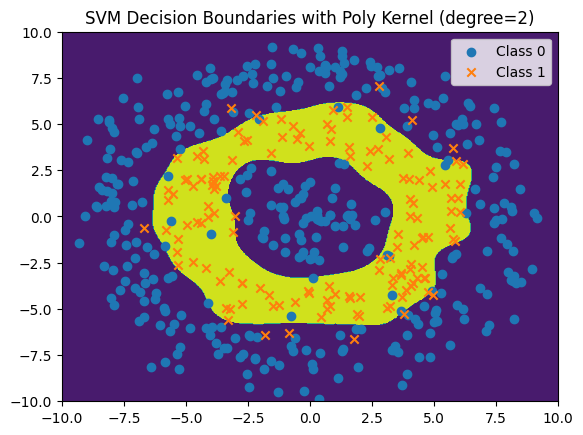

In [118]:
from sklearn.svm import SVC

svm = SVC(C=1, gamma='auto',kernel='rbf')
svm.fit(X,y)
data = svm.predict(Xgrid)
data = np.reshape(data, [points,points])

plt.contourf(x1line,x2line,data)
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.scatter(X[y==0,0],X[y==0,1],label='Class 0',marker='o')
plt.scatter(X[y==1,0],X[y==1,1],label='Class 1',marker='x')
plt.title('SVM Decision Boundaries with Poly Kernel (degree=2)')
plt.legend()

In [119]:
from sklearn.model_selection import KFold

n_splits = 5
kf = KFold(n_splits, shuffle=True)
fraction_correct_train = 0
fraction_correct_test = 0

for train_index, test_index in kf.split(X):
    # Creating the training and test data set
    # we train K-1 data and test K data
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]

    # using X_train, y_train to train the SVM
    svm = SVC(C=0.03, gamma='auto' ,kernel='rbf')
    svm.fit(X_train,y_train)
    
    # predict the output for the test data set
    y_test_predict = svm.predict(X_test)

    # loop to find out if the data is classified correctly
    classified_correct = 0
    classified_incorrectly = 0
    for i in range(0,len(y_test)):
        # seeing if the test data class is the same as the predicted data class
        if y_test[i] == y_test_predict[i]:
            classified_correct += 1
        else:
            classified_incorrectly +=1
    # calculating the fraction classfied correctly 
    fraction_correct_test += classified_incorrectly/classified_correct
    
    ### doing the same prediction for the training set and evaluating error
    y_train_predict = svm.predict(X_train)

        # loop to find out if the data is classified correctly
    classified_correct = 0
    classified_incorrectly = 0
    for i in range(0,len(y_train)):
        # seeing if the test data class is the same as the predicted data class
        if y_train[i] == y_train_predict[i]:
            classified_correct += 1
        else:
            classified_incorrectly +=1
    # calculating the fraction classfied correctly 
    fraction_correct_train += classified_incorrectly/classified_correct


## calculating the fraction of data classfied correctly
fraction_correct_train = np.round((1- fraction_correct_train/n_splits)*100,2)
fraction_correct_test = np.round((1- fraction_correct_test/n_splits)*100,2)
print('Testing data classified correctly:',fraction_correct_test)
print('Training data classified incorrectly:',fraction_correct_train)



Testing data classified correctly: 59.87
Training data classified incorrectly: 59.94


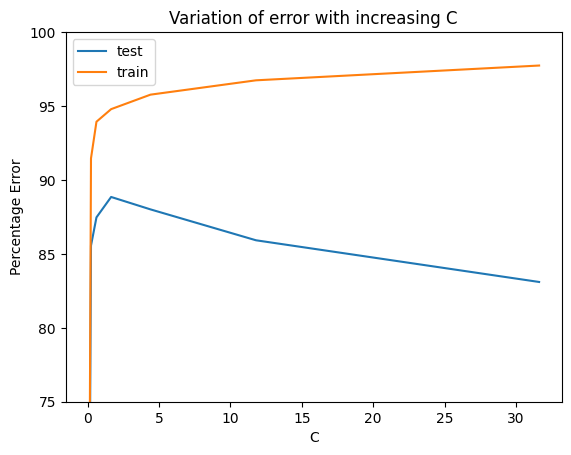

In [152]:
#### plotting the graph of error as C varies

n_splits = 5
kf = KFold(n_splits, shuffle=True)

# function to return the error from given data set
def classified_error(C_input,n_splits):
    fraction_correct_train = 0
    fraction_correct_test = 0
    for train_index, test_index in kf.split(X):
        # Creating the training and test data set
        # we train K-1 data and test K data
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]

        # using X_train, y_train to train the SVM
        svm = SVC(C=C_input, gamma='auto' ,kernel='rbf')
        svm.fit(X_train,y_train)
        
        # predict the output for the test data set
        y_test_predict = svm.predict(X_test)

        # loop to find out if the data is classified correctly
        classified_correct = 0
        classified_incorrectly = 0
        for i in range(0,len(y_test)):
            # seeing if the test data class is the same as the predicted data class
            if y_test[i] == y_test_predict[i]:
                classified_correct += 1
            else:
                classified_incorrectly +=1
        # calculating the fraction classfied correctly 
        fraction_correct_test += classified_incorrectly/classified_correct
        
        ### doing the same prediction for the training set and evaluating error
        y_train_predict = svm.predict(X_train)

            # loop to find out if the data is classified correctly
        classified_correct = 0
        classified_incorrectly = 0
        for i in range(0,len(y_train)):
            # seeing if the test data class is the same as the predicted data class
            if y_train[i] == y_train_predict[i]:
                classified_correct += 1
            else:
                classified_incorrectly +=1
        # calculating the fraction classfied correctly 
        fraction_correct_train += classified_incorrectly/classified_correct
    fraction_correct_train = np.round((1- fraction_correct_train/n_splits)*100,2)
    fraction_correct_test = np.round((1- fraction_correct_test/n_splits)*100,2)
    return fraction_correct_test, fraction_correct_train

## calculating the fraction of data classfied and plotting how this varies as correctly
nC = np.power(10, np.linspace(-1.5, 1.5, 8))
fraction_correct_test = np.zeros(len(nC))
fraction_correct_train = np.zeros(len(nC))

index = 0
for i in nC:
    fraction_correct_test[index], fraction_correct_train[index] = classified_error(i,n_splits)
    index += 1

plt.plot(nC,fraction_correct_test,label= 'test')
plt.plot(nC,fraction_correct_train,label = 'train')
plt.title('Variation of error with increasing C')
plt.xlabel('C')
plt.ylabel('Percentage Error')
plt.ylim(75,100)
plt.legend()

